<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2018 </h1>

<H3 align='center'> Tarea 0 - Introducción a Máquinas de Aprendizaje </H3>
<hr style="height:2px;border:none"/>

**Temas**  
* Introducción a librerías comunes de *Machine Learning*:
    * Pandas
    * Numpy
    * Sklearn
    * Matplotlib,..
* Clasificación y regresión sobre texto.
* Implementación a mano de regresión lineal.
* Algoritmo Gradiente descendente
 

** Formalidades **  
* Equipos de trabajo de: 2 personas
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 5 de Octubre.
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<francisco.mena.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<jnancu@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea0-INF393-II-2018]

<hr style="height:2px;border:none"/>

La tarea se divide en secciones:

[1.](#primero) Sentiment Analysis  
[2.](#segundo) Job Salary Prediction  
[3.](#tercero) Linear Regression by hand

<a id="primero"></a>
## 1. Sentiment Analysis [Sin evaluación]
El análisis de emociones o sentimientos se refiere al proceso de extraer información acerca de la actitud
que una persona (o grupo de ellas) manifiesta, en un determinado medio o formato digital, con respecto a un
tópico o contexto de comunicación. Uno de los casos más estudiados corresponde a determinar la polaridad
de un trozo de texto, es decir, clasificar una determinada evaluación escrita (*review*), en que una persona
manifiesta una opinión, como *positiva*, *negativa* o *neutral*. Esto también ha sido extendido a otros medios, como lo es analizar la polaridad de textos en redes sociales.  

<img src="https://cdn.urgente24.com/sites/default/files/notas/2018/01/18/twitter.png" title="Title text" width="20%" height="20%" />


La conocida red social Twitter tiene una gran cantidad de usuarios, por lo que la información se genera a
cada segundo, donde el análisis de texto se ha aplicado fuertemente a estos medios sociales. La dificultad de
este problema radica en el carácter altamente ambiguo e informal del lenguaje que utilizan naturalmente las
personas ası́ como el manejo de negaciones, sarcasmo y abreviaciones en una frase.


Los datos pueden ser descargados ejecutando el siguiente código en sistema Unix:
```
wget -O train_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.train
wget -O test_data.csv http://www.inf.utfsm.cl/~jnancu/stanford-subset/polarity.dev
```

Para construir un clasificador que determine automáticamente la polaridad de un trozo de texto, vamos a necesitar representar los textos $\{d_i\}_{i=1}^n$ disponibles como vectores de caracterı́sticas (features). Para aumentar la eficacia de las caracterı́sticas extraı́das es conveniente ejecutar algunas técnicas de pre-procesamiento básicas como: pasar todo el texto a minúsculas (lower-casing), eliminar signos de puntuación
y eliminar palabras sin significado como artı́culos, pronombres y preposiciones (*stop word removal*). Otra
técnica que suele ser útil para obtener buenas caracterı́sticas (*features*) es la lematización, es decir, la
reducción de todas las palabras a su tronco léxico base. Una técnica similar y más utilizada en la práctica es el stemming. Varias de éstas están implementadas en la libreria nltk [13] para python.


> a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros
por clase y describa el dataset.
``` python
import pandas as pd
ftr = open("train_data.csv", "r")
fts = open("test_data.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = pd.to_numeric(df_train['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
df_test = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_test['Sentiment'] = pd.to_numeric(df_test['Sentiment'])
df_train.shape
```

> b) Construya un conjunto de validación (también conocido como *hold out validation*), a través de una máscara aleatoria, para verificar los resultados de los algoritmos.
``` python
import numpy as np
msk = np.random.rand(len(df_train)) < 0.8
df_new_train = df_train[msk]
df_val = df_train[~msk]
```

> c) Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato estándarizado
en el cual se podrán trabajar.
```python
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer
def word_extractor(text):
    wordlemmatizer = WordNetLemmatizer()
    wordstemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordstemmer.stem(word.lower())for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words
word_extractor("I love to eat cake")
word_extractor("I love eating cake")
word_extractor("I loved eating the cake")
word_extractor("I do not love eating cake")
word_extractor("I don't love eating cake")
...
wordlemmatizer.lemmatize(word.lower()) #can use this
```

> d) Utilizando la función *CountVectorizer* de la librerı́a sklearn genere una representación vectorial del texto de entrenamiento y del conjunto que usaremos para realizar la validación. Esta función consiste en contar cuántas veces aparecen ciertos términos/palabras en el texto a través de un vocabulario que construiremos mediante la unión de todas las palabras que observemos en los textos que tenemos a disposición. Explore el vocabulario utilizado y determine cuáles son las palabras más frecuentes en el conjunto de entrenamiento y validación.
``` python
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
texts_train = [word_extractor(text) for text in df_new_train.Text]
texts_val = [word_extractor(text) for text in df_val.Text]
texts_test = [word_extractor(text) for text in df_test.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train))
features_train = vectorizer.transform(texts_train)
features_val = vectorizer.transform(texts_val)
features_test = vectorizer.transform(texts_test)
labels_train = np.asarray((df_new_train.Sentiment.astype(float)+1)/2.0)
labels_val = np.asarray((df_val.Sentiment.astype(float)+1)/2.0)
labels_test = np.asarray((df_test.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train.sum(axis=0)).reshape(-1,))
for tag, count in zip(vocab, dist):
    print count, tag
```

> e) Construya una función que entrene/ajuste un modelo de Regresión Logı́stica y mida el error de predicción obtenido sobre los datos de entrenamiento y validación. Experimente con variar la representación o preprocesamiento, por ejemplo el efecto de filtrar *stopwords* y de eliminar este paso de
pre-procesamiento tı́pico. Determine además, qué representación obtiene un mejor resultado: si aquella obtenida vı́a lematización o aquella obtenida vı́a *stemming*. Seleccione el mejor modelo y mida sobre *test*. Comente
``` python
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv):
    model = LogisticRegression()
    model = model.fit(x, y)
    print("Accuracy under training: ",model.score(x,y))
    print("Accuracy under validation: ",model.score(xv,yv))
    return model
log_model = do_LOGIT(features_train,labels_train,features_val,labels_val)
```

> f) Finalmente, tome un subconjunto aleatorio de los textos de prueba y analice las predicciones del modelo (explore las predicciones, ası́ como las probabilidades que el clasificador asigna a cada clase)

Para el desarrollo de ésta actividad se trabajará con el típico problema de identificar el sentimiento de un texto escrito en su forma bruta, extrayendo características y luego clasificandolo como positivo o negativo....

Se trabajará con unos datos de la red social Twitter..

> a) Construya un dataframe con los datos a analizar. Determine cuántas clases existen, cuántos registros por clase y describa el dataset.

In [1]:
import pandas as pd
ftr = open("train_data.csv", "r")
fts = open("test_data.csv", "r")
rows = [line.split(" ",1) for line in ftr.readlines()]
df_train = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_train['Sentiment'] = pd.to_numeric(df_train['Sentiment'])
rows = [line.split(" ",1) for line in fts.readlines()]
df_test = pd.DataFrame(rows, columns=['Sentiment','Text'])
df_test['Sentiment'] = pd.to_numeric(df_test['Sentiment'])
df_train.shape


(3554, 2)

In [5]:
df_train["Sentiment"].unique()

array([-1,  1])

In [6]:
df_train["Sentiment"].value_counts()

-1    1784
 1    1770
Name: Sentiment, dtype: int64

Se prefiere mostrar de manera visual para mejor visualización

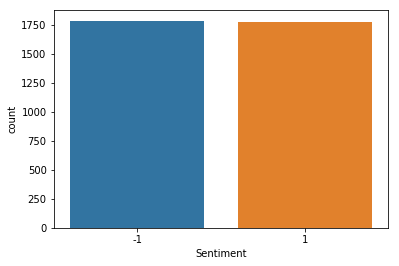

In [8]:
import seaborn as sns
%matplotlib inline
sns.countplot(x='Sentiment',data=df_train)

contestar pregunta

> b) Construya un conjunto de validación (también conocido como hold out validation), a través de una máscara aleatoria, para verificar los resultados de los algoritmos.

In [9]:
import numpy as np
msk = np.random.rand(len(df_train)) < 0.8
df_new_train = df_train[msk]
df_val = df_train[~msk]
print("Conjunto de entrenamiento: ",df_new_train.shape)
print("Conjunto de validacion: ",df_val.shape)

('Conjunto de entrenamiento: ', (2855, 2))
('Conjunto de validacion: ', (699, 2))


Quedamos con menos datos de entrenamiento ya que se extrajo un conjunto para validacion,...

> c) Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato estándarizado en el cual se podrán trabajar.

In [15]:
import re, time
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer, word_tokenize
from nltk.stem.porter import PorterStemmer

def word_extractor1(text):
    wordstemmer = PorterStemmer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordstemmer.stem(word.lower())for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

def word_extractor2(text):
    wordlemmatizer = WordNetLemmatizer()
    commonwords = stopwords.words('english')
    text = re.sub(r'([a-z])\1+', r'\1\1',text)#substitute multiple letter by two
    words = ""
    wordtokens = [ wordlemmatizer.lemmatize(word.lower()) for word in word_tokenize(text.decode('utf-8', 'ignore')) ]
    for word in wordtokens:
        if word not in commonwords:
            words+=" "+word
    return words

print(word_extractor1("I love to eat cake"))
print(word_extractor1("I love eating cake"))
print(word_extractor1("I loved eating the cake"))
print(word_extractor1("I do not love eating cake"))
print(word_extractor1("I don't love eating cake"))

print(word_extractor2("I love to eat cake"))
print(word_extractor2("I love eating cake"))
print(word_extractor2("I loved eating the cake"))
print(word_extractor2("I do not love eating cake"))
print(word_extractor2("I don't love eating cake"))

 love eat cake
 love eat cake
 love eat cake
 love eat cake
 n't love eat cake
 love eat cake
 love eating cake
 loved eating cake
 love eating cake
 n't love eating cake


Se puede ver la diferencia entre estos dos procesos y se explica por...

también mostramos otros ejemplos

In [18]:
print(word_extractor1("I saw a little sharkies"))
print(word_extractor2("I saw a little sharky"))

 saw littl sharki
 saw little sharky


> d) Utilizando la función CountVectorizer de la librerı́a sklearn genere una representación vectorial del texto de entrenamiento y del conjunto que usaremos para realizar la validación. Esta función consiste en contar cuántas veces aparecen ciertos términos/palabras en el texto a través de un vocabulario que construiremos mediante la unión de todas las palabras que observemos en los textos que tenemos a disposición. Explore el vocabulario utilizado y determine cuáles son las palabras más frecuentes en el conjunto de entrenamiento y pruebas.

In [43]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

texts_train1 = [word_extractor1(text) for text in df_new_train.Text]
texts_val1 = [word_extractor1(text) for text in df_val.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train1))
features_train1 = vectorizer.transform(texts_train1)
features_val1 = vectorizer.transform(texts_val1)
labels_train = np.asarray((df_new_train.Sentiment.astype(float)+1)/2.0)
labels_val = np.asarray((df_val.Sentiment.astype(float)+1)/2.0)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train1.sum(axis=0)).reshape(-1,))
for tag, count in zip(vocab, dist):
    print count, tag


6 10
2 100
1 101
1 105
1 10th
3 11
2 110
1 11th
1 12
1 13th
1 14
1 140
2 15
1 16
1 163
1 170
1 18th
4 19
2 1915
1 1934
1 1938
1 1940
1 1950
1 1955
1 1958
1 1959
1 1960
1 1967
3 1975
1 1979
1 1980
1 1991
1 1995
2 19th
3 20
2 2002
3 20th
2 21st
1 22
1 24
1 25
3 30
2 3000
1 37
1 3d
4 40
1 400
1 401
1 451
1 49
3 4ever
3 50
1 51
1 5th
1 60s
1 65
1 65th
1 70
1 71
1 77
1 78
1 79
5 80
1 800
2 84
2 85
1 88
1 8th
13 90
1 93
2 95
1 99
1 aaliyah
2 abandon
1 abbass
1 abbrevi
1 abc
2 abel
1 abhorr
1 abid
8 abil
4 abl
2 abli
1 aboul
13 abov
3 above
1 abraham
1 abras
2 abroad
1 abruptli
8 absolut
8 absorb
1 absorpt
4 abstract
5 absurd
2 absurdist
1 absurdli
4 abus
1 abysm
1 acabamo
1 academ
2 academi
4 accent
1 accentu
2 accept
9 access
1 accid
2 accident
3 accompani
5 accomplish
1 accord
7 account
3 accur
1 acerta
1 ach
13 achiev
1 achil
3 achingli
1 achronolog
1 acid
3 acknowledg
1 acolyt
1 acr
1 acrid
7 across
59 act
1 acting
49 action
3 activ
43 actor
2 actorli
11 actress
1 actuacion
15 actual
5 a

1 consciousness
1 consequ
1 conserv
10 consid
3 consider
1 consiglier
1 consign
5 consist
1 consol
3 conspicu
1 conspiraci
1 conspiratori
1 constant
5 constantli
1 constrict
12 construct
2 consum
1 contagi
5 contain
2 contempl
8 contemporari
1 contemptu
1 contend
1 contenido
3 content
1 contentedli
2 contest
5 context
1 contin
2 continu
3 contradict
2 contradictori
2 contrapt
2 contrari
2 contrast
2 contribut
13 contriv
8 control
1 contruct
1 convenc
2 conveni
9 convent
5 convers
3 convert
7 convey
2 convict
14 convinc
1 convolut
1 cook
1 cooker
9 cool
1 coolidg
1 cooper
7 cop
2 cope
2 copi
1 copmovieland
1 copout
3 coppola
2 cor
1 corbett
1 core
2 corner
1 corni
1 corporate
3 corps
2 correct
5 cost
1 costli
1 costner
5 costum
57 could
1 coulda
6 count
2 counterpart
2 counti
3 countless
5 countri
8 coupl
3 courag
11 cours
1 court
1 courtroom
1 coutur
4 cover
1 cowardli
1 cower
1 cowrot
1 cox
3 cq
4 crack
1 crackerjack
2 crackl
1 cradl
6 craft
2 craftsmanship
1 craig
2 cram
1 crane
1 cr

1 heidi
1 height
2 heighten
1 heinou
1 heist
6 held
1 helen
1 helga
9 hell
1 hellish
2 helm
21 help
1 hem
1 hen
2 henri
1 her
1 herbivor
1 herd
1 heritag
1 hermet
1 hermocr
11 hero
1 heroic
2 heroin
3 herzog
2 hewitt
4 hey
1 heyday
140 hi
1 hibiscu
2 hick
1 hickenloop
1 hidden
4 hide
1 hidebound
1 hideous
1 hierarchi
26 high
2 higher
2 highest
1 highland
7 highli
1 highlight
1 highly
1 highway
1 hijack
3 hilar
8 hilari
4 hill
1 hindsight
2 hing
2 hint
12 hip
1 hippopotamu
1 hire
10 histor
21 histori
1 historia
2 histrion
20 hit
1 hitchcock
1 hitler
1 hitman
1 hitmen
1 hiv
1 hjelj
1 hlne
2 ho
1 hobbl
1 hobnail
1 hodgepodg
4 hoffman
2 hokey
2 hokum
9 hold
1 holden
9 hole
2 holi
7 holiday
1 holli
2 hollow
35 hollywood
4 holm
2 holocaust
1 holofcen
1 hom
3 homag
16 home
1 homicid
1 homilet
1 homo
1 homogen
1 homosexu
1 hon
15 honest
4 honesti
3 honestli
1 honey
4 hong
2 honor
6 hop
20 hope
2 hopeless
1 hopelessli
2 hopkin
1 hopkins
1 hord
1 horn
1 horner
1 horrend
6 horribl
2 horrid
6 horr

1 own
2 owner
2 ozpetek
1 pac
15 pace
2 pacino
10 pack
1 packag
1 pact
2 pad
1 padr
1 paean
1 pageant
1 pageantri
2 paid
16 pain
1 painkil
1 painless
6 paint
1 pair
2 palestinian
2 palma
1 paltrow
1 pamela
2 pan
1 pandemonium
1 pander
1 panic
2 panoram
3 pant
2 pantheon
1 papa
7 paper
1 papin
1 par
2 para
5 parabl
2 parad
1 paradigm
1 paradiso
2 parallel
2 paranoia
9 parent
1 pari
4 park
1 parka
3 parker
5 parodi
1 parrot
25 part
3 parti
1 particip
2 participatori
3 particular
9 particularli
1 partir
2 partli
2 partway
7 pass
2 passabl
1 passag
1 passatempo
20 passion
1 passiv
1 passive
17 past
1 pasta
1 pasti
1 pastich
1 pastri
1 pat
3 patch
1 patchwork
5 path
3 pathet
4 patho
4 patholog
3 patienc
4 patient
1 patric
2 patron
1 patter
1 pattern
1 paul
1 paulett
1 paulin
1 paus
2 paxton
10 pay
5 payoff
1 pb
1 pea
2 peac
2 peak
1 pearl
1 peculiar
1 peculiarli
1 pedagogi
1 peddl
1 pedest
2 pedestrian
2 pedigre
1 pedro
1 peek
1 peev
1 peg
1 pellington
1 pelosi
2 penalti
2 penetr
1 penn
1 p

18 sweet
2 sweetest
2 sweetheart
4 sweetli
2 swept
3 swim
1 swimfan
1 swimmer
3 swing
1 swipe
1 swoop
1 sword
1 sydow
5 symbol
1 symmetr
3 sympathet
2 sympathi
1 symptom
2 synch
1 synchron
1 system
1 systemat
2 tabl
1 tabloid
1 taboo
1 tacki
4 tackl
1 tactic
1 tadpol
1 tag
1 taint
1 taiwanes
2 tak
1 takashi
73 take
7 taken
1 takeoff
3 tal
40 tale
16 talent
12 talk
3 talki
2 tall
1 tambm
1 tamer
1 tan
1 tang
1 tangl
1 tango
1 tanov
1 tantamount
6 tap
1 tape
2 tarantino
1 tarantula
1 tardier
9 target
1 tarkovski
2 tart
1 tartli
3 task
12 tast
2 tasteless
7 tasti
1 tat
1 tatter
3 tattoo
1 taunt
3 taut
1 taverni
2 tax
1 tay
2 taylor
1 taymor
1 tchaikovski
1 tea
3 teach
4 teacher
1 team
10 tear
2 tearjerk
2 teas
1 tech
1 techi
4 technic
1 techniqu
1 techno
4 technolog
16 tediou
1 tedium
1 teem
20 teen
9 teenag
1 teendom
2 teeth
2 telegraph
1 telemarket
1 telenovela
1 telephon
1 teleprompt
6 televis
27 tell
1 templ
3 tempt
1 temptat
2 ten
1 tenaci
5 tend
3 tendenc
5 tender
1 tennesse
1 tenor

In [34]:
features_train1.get_shape()

(2855, 7118)

el tamanno del vocab es. ..

In [44]:
sorted_by_second = sorted(zip(vocab,dist), key=lambda tup: tup[1])[::-1]
sorted_by_second

[(u'film', 460),
 (u'movi', 374),
 (u'thi', 344),
 (u'like', 223),
 (u'one', 203),
 (u'ha', 185),
 (u'make', 172),
 (u'stori', 144),
 (u'hi', 140),
 (u'charact', 129),
 (u'comedi', 121),
 (u'good', 120),
 (u'even', 118),
 (u'time', 116),
 (u'doe', 108),
 (u'work', 103),
 (u'much', 101),
 (u'perform', 99),
 (u'look', 96),
 (u'well', 93),
 (u'way', 93),
 (u'feel', 91),
 (u'littl', 88),
 (u'get', 87),
 (u'director', 83),
 (u'funni', 80),
 (u'onli', 78),
 (u'never', 75),
 (u'take', 73),
 (u'veri', 72),
 (u'enough', 71),
 (u'thing', 70),
 (u'end', 70),
 (u'best', 69),
 (u'bad', 69),
 (u'seem', 68),
 (u'entertain', 67),
 (u'love', 66),
 (u'wa', 65),
 (u'life', 65),
 (u'would', 64),
 (u'see', 63),
 (u'watch', 62),
 (u'noth', 61),
 (u'come', 61),
 (u'cast', 61),
 (u'us', 60),
 (u'audienc', 60),
 (u'act', 59),
 (u'drama', 57),
 (u'could', 57),
 (u'plot', 56),
 (u'may', 56),
 (u'fun', 55),
 (u'go', 54),
 (u'realli', 53),
 (u'filmmak', 53),
 (u'two', 52),
 (u'made', 52),
 (u'ani', 52),
 (u'year',

In [37]:
texts_train2 = [word_extractor2(text) for text in df_new_train.Text]
texts_val2 = [word_extractor2(text) for text in df_val.Text]
vectorizer = CountVectorizer(ngram_range=(1, 1), binary='False')
vectorizer.fit(np.asarray(texts_train2))
features_train2 = vectorizer.transform(texts_train2)
features_val2 = vectorizer.transform(texts_val2)
vocab = vectorizer.get_feature_names()
dist=list(np.array(features_train2.sum(axis=0)).reshape(-1,))
for tag, count in zip(vocab, dist):
    print count, tag


6 10
2 100
1 101
1 105
1 10th
3 11
2 110
1 11th
1 12
1 13th
1 14
1 140
2 15
1 16
1 163
1 170
1 18th
4 19
2 1915
1 1934
1 1938
1 1940s
1 1950s
1 1955
1 1958
1 1959
1 1960s
1 1967
3 1975
1 1979
1 1980
1 1991
1 1995
2 19th
3 20
2 2002
3 20th
2 21st
1 22
1 24
1 25
2 30
2 3000
1 30s
1 37
1 3d
3 40
1 400
1 401
1 40s
1 451
1 49
3 4ever
3 50
1 51
1 5ths
1 60s
1 65
1 65th
1 70s
1 71
1 77
1 78
1 79
3 80
1 800
2 80s
2 84
2 85
1 88
1 8th
12 90
1 90s
1 93
2 95
1 99
1 aaliyah
2 abandon
1 abbass
1 abbreviated
1 abc
2 abel
1 abhorrent
1 abiding
8 ability
4 able
2 ably
1 aboul
3 above
1 abrahams
1 abrasive
2 abroad
1 abruptly
2 absolute
6 absolutely
1 absorb
7 absorbing
1 absorption
4 abstract
2 absurd
2 absurdist
3 absurdity
1 absurdly
4 abuse
1 abysmally
1 acabamos
1 academic
2 academy
4 accent
1 accentuating
1 accept
1 accepting
9 accessible
2 accident
1 accidental
1 accompanies
2 accompanying
3 accomplished
1 accomplishes
1 accomplishment
1 according
6 account
1 accountant
2 accurate
1 accurately
1

5 club
2 clue
3 clueless
1 clumsily
1 clumsiness
8 clumsy
1 clunk
2 clunker
1 clunkiness
2 clunky
1 clutch
11 co
1 coal
1 coarse
3 coaster
1 coating
3 cobbled
1 cockettes
1 cocky
3 code
1 cogent
1 coherence
4 coherent
1 cohesion
3 cohesive
2 coincidence
1 coke
14 cold
1 coldly
1 collaboration
2 collapse
2 collateral
1 collected
3 collection
2 collectively
10 college
1 collegiate
1 collie
3 collision
1 colonialist
1 colonic
9 color
2 colored
9 colorful
1 colorfully
1 colosseum
1 coloured
1 columbine
2 columbus
3 com
2 coma
1 comatose
2 combat
2 combination
5 combine
2 combined
1 combustible
51 come
1 comeamos
4 comedian
3 comedic
124 comedy
3 comfort
3 comfortable
1 comforting
1 comfy
17 comic
2 comically
18 coming
2 command
1 comment
1 commentary
1 commenting
1 commerce
4 commercial
2 commercialism
3 commitment
3 committed
1 commodity
2 common
1 commonplace
1 commune
1 communicates
1 communion
6 community
1 como
2 companion
4 company
2 compare
2 compared
1 comparison
2 compassion
22 co

1 france
5 franchise
2 franco
1 francophile
2 frank
1 frankenstein
1 franklin
1 franois
2 frantic
1 franz
2 fraser
2 frat
1 frayed
1 frazzled
2 freak
3 freaky
1 fred
8 free
2 freedom
1 freeing
1 freely
1 frei
15 french
3 frenetic
1 frenzy
2 frequent
5 frequently
12 fresh
1 freshened
1 freshman
1 freshness
1 freundlich
3 frida
8 friday
1 friel
8 friend
5 friendly
1 friends
5 friendship
3 frightening
1 frighteningly
2 frills
1 frio
1 fritter
1 frodo
2 front
4 frontal
1 frontman
1 frosty
1 frothy
1 frown
1 fruitful
1 frustrates
3 frustrating
2 frustratingly
2 frustration
1 fu
1 fuddy
1 fudge
1 fudged
1 fuel
1 fueled
1 fuertes
1 fuhrman
1 fulfilling
2 fulford
37 full
1 fullness
6 fully
1 fumble
1 fumbling
55 fun
1 funcionar
2 function
1 fundadas
1 funeral
1 funk
6 funnier
5 funniest
80 funny
1 funnybone
1 furiously
1 furnished
1 furrow
1 fury
1 fuse
1 fusion
1 fuss
2 futile
11 future
1 futuristic
1 futuro
1 fuzziness
3 fuzzy
1 ga
1 gadget
16 gag
1 gaghan
1 gai
1 gain
1 gaining
2 gainsbourg

1 lunar
1 lunatic
1 lunch
1 lunchers
1 lurch
1 lured
2 luridly
1 lurking
1 luscious
3 lush
1 luster
1 lustrous
1 luther
1 lying
1 lynching
2 lyric
3 lyrical
1 lyricism
1 macabre
1 macdowell
1 machination
8 machine
1 machinery
3 machismo
1 macnaughton
2 macy
4 mad
2 maddening
54 made
5 madness
5 madonna
1 maelstrom
1 maggot
5 magic
1 magical
1 magnetic
2 magnificent
1 magnifique
1 mai
4 maid
1 maiden
1 maik
5 main
1 mainland
3 mainly
4 mainstream
2 maintain
2 maintaining
3 maintains
1 majesty
1 majid
2 majidi
6 major
1 majority
150 make
7 maker
2 makhmalbaf
1 makin
27 making
1 malarkey
1 malcolm
4 male
1 malice
4 malkovich
1 mall
1 malle
1 malleable
1 malnourished
2 mamet
31 man
1 mana
5 manage
2 managed
18 manages
1 managing
1 manchild
1 mandate
1 mandy
1 mangle
3 manhattan
1 maniac
2 manipulation
1 manipulative
2 mann
8 manner
1 mannered
1 mannerism
1 manufactured
46 many
1 map
1 mapquest
2 mar
1 marathon
3 marching
1 marcus
1 margin
2 marginal
1 marina
1 marinated
2 marine
9 mark
1 m

1 reverie
1 reversal
1 reviewed
1 revolt
1 revolting
5 revolution
2 revolutionary
3 reward
1 rewarded
6 rewarding
1 reworked
1 reworking
2 reyes
1 rez
1 rhapsodizes
2 rhetoric
1 rhino
8 rhythm
1 ribbing
3 rice
12 rich
2 richard
2 richer
4 richly
2 richness
1 ridden
1 riddled
10 ride
2 rider
7 ridiculous
1 ridiculousness
1 riding
1 rife
2 riff
1 rifkin
2 rigged
33 right
1 righteousness
1 rigid
1 rigidly
3 rigor
1 rigorous
6 ring
1 ringing
1 ringu
3 rip
3 ripe
1 ripoff
2 ripper
1 risa
9 rise
4 rising
2 risk
1 risky
2 ritchie
1 rite
2 rival
1 rivalry
1 river
2 riveted
6 riveting
10 road
1 roadside
1 roar
1 roaring
2 rob
11 robert
2 roberto
1 robin
1 robust
12 rock
1 rockwell
1 rodrigues
4 rodriguez
5 roger
3 rohmer
1 rohypnol
1 roiling
1 roland
17 role
3 roll
1 rolled
3 roller
3 rolling
4 roman
14 romance
33 romantic
1 romanticism
1 romero
1 romijn
1 romoli
1 romp
7 room
6 root
1 rooted
3 rooting
1 rope
1 rosa
1 rosario
4 rose
1 roster
3 rote
1 rotten
1 rouge
2 rough
1 roughage
1 roughly


1 unrelated
2 unrelentingly
1 unremarkable
1 unrepentantly
1 unrewarding
1 unruly
1 unsaid
3 unsatisfying
1 unsavory
1 unscathed
1 unschooled
2 unsentimental
6 unsettling
1 unsettlingly
1 unshapely
1 unsteady
1 unsubtle
1 unsuccessful
1 unsuccessfully
2 unsure
1 unsurprising
1 unsuspecting
1 unsympathetic
1 untold
1 untrained
1 unturned
4 unusual
3 unusually
1 unwatchable
1 unwavering
3 unwieldy
1 unwillingness
14 up
2 upbeat
1 update
2 updating
1 upholstered
1 uplift
3 uplifting
1 upload
9 upon
3 upper
1 upping
1 uproar
4 ups
1 upsetting
2 upside
9 urban
3 urge
3 urgency
2 urgent
13 us
8 use
9 used
1 useless
1 user
3 using
12 usual
7 usually
1 utilizes
4 utter
6 utterly
1 uzumaki
3 vague
1 vaguely
1 valentine
1 valiantly
1 valid
1 validated
2 valuable
12 value
6 vampire
3 van
1 vanished
1 vapid
1 vaporize
1 vardalos
1 variable
1 variant
4 variation
1 variety
3 various
1 vast
1 vat
30 ve
1 veces
1 vector
3 veers
7 vehicle
1 veiled
1 veiling
1 veljohnson
1 velma
2 velocity
1 venality
2 

In [38]:
features_train2.get_shape()

(2855, 8591)

acá el tamanno es distinto xke.. bla

In [42]:
sorted_by_second = sorted(zip(vocab,dist), key=lambda tup: tup[1])[::-1]
sorted_by_second

[(u'film', 453),
 (u'movie', 378),
 (u'like', 205),
 (u'one', 203),
 (u'ha', 185),
 (u'make', 150),
 (u'story', 144),
 (u'character', 130),
 (u'comedy', 124),
 (u'even', 118),
 (u'good', 117),
 (u'time', 112),
 (u'doe', 108),
 (u'much', 101),
 (u'way', 93),
 (u'well', 92),
 (u'performance', 90),
 (u'little', 89),
 (u'work', 88),
 (u'life', 88),
 (u'director', 83),
 (u'funny', 80),
 (u'look', 77),
 (u'get', 77),
 (u'never', 75),
 (u'feel', 73),
 (u'enough', 71),
 (u'thing', 70),
 (u'best', 69),
 (u'bad', 69),
 (u'wa', 65),
 (u'would', 64),
 (u'take', 62),
 (u'nothing', 61),
 (u'audience', 61),
 (u'drama', 57),
 (u'could', 57),
 (u'may', 56),
 (u'see', 55),
 (u'fun', 55),
 (u'made', 54),
 (u'really', 53),
 (u'two', 52),
 (u'end', 52),
 (u'action', 52),
 (u'minute', 51),
 (u'love', 51),
 (u'come', 51),
 (u'cast', 51),
 (u'year', 50),
 (u'plot', 49),
 (u'every', 49),
 (u'big', 49),
 (u'something', 48),
 (u'also', 48),
 (u'without', 47),
 (u'though', 47),
 (u'many', 46),
 (u'long', 46),
 (u

> e) Construya una función que entrene/ajuste un modelo de Regresión Logı́stica y mida el error de predicción obtenido sobre los datos de entrenamiento y validación. Experimente con variar la representación o preprocesamiento, por ejemplo el efecto de filtrar stopwords y de eliminar este paso de pre-procesamiento tı́pico. Determine además, qué representación obtiene un mejor resultado: si aquella obtenida vı́a lematización o aquella obtenida vı́a stemming. Seleccione el mejor modelo y mida sobre test. Comente



In [45]:
from sklearn.linear_model import LogisticRegression
def do_LOGIT(x,y,xv,yv):
    model = LogisticRegression()
    model = model.fit(x, y)
    print("Accuracy under training: ",model.score(x,y))
    print("Accuracy under validation: ",model.score(xv,yv))
    return model
print("con stemming")
log_model1 = do_LOGIT(features_train1,labels_train,features_val1,labels_val)
print("con lemmatization")
log_model2 = do_LOGIT(features_train2,labels_train,features_val2,labels_val)


con stemming
('Accuracy under training: ', 0.9863397548161121)
('Accuracy under validation: ', 0.7410586552217453)
con lemmatization
('Accuracy under training: ', 0.9919439579684763)
('Accuracy under validation: ', 0.7296137339055794)


In [ ]:
https://github.com/FMena14/MachineLearning2/blob/master/Parte2.ipynb

<a id="segundo"></a>
## 2. Job Salary Prediction

En esta sección se trabajará con el problema de predecir el salario que ofrece un anuncio en internet a través unicamente del texto del anuncio. El dataset es ofrecido por *Adzuna* como una competencia en la plataforma más grande de *data science* Kaggle, a través del siguiente __[link](https://www.kaggle.com/c/job-salary-prediction)__. El objetivo de la competencia, según *Adzuna*, es el de tener un motor que pueda predecir el salario de cualquier anuncio de trabajo en Reunio Unido, para poder mejorar la experiencia de los usuarios que buscan trabajos, ya que así pueden filtrar sin que el mismo empleador señale explícitamente cuánto paga.

<img src="http://s5047.pcdn.co/wp-content/uploads/2013/05/salary-prediction-engine-v2.png" title="Title text" width="50%"/>

La métrica de evaluación de la competencia es MAE (*mean absolute error*):

$$
L = \frac{1}{N} \sum_i^N  \mid y - \hat{y} \mid
$$


Para descargar los datos a utilizar (*Train_rev1*) debe estar registrado en la plataforma de Kaggle. Se cuenta con cientos de miles registros con textos sin procesar, es decir, no están estructurados.


> a) Carge los datos *csv* de entrenamiento y cree un conjunto de validación con los últimos 10 mil datos en un dataframe de *pandas*. Describa los datos, apóyese de gráficos ¿Cuántos datos hay en cada conjunto?  
```python
import pandas as pd
df = pd.read_csv("Train_rev1.csv")
df_train = df.iloc[:-10000]
df_val = df.iloc[-10000:]
...#load other sets
df.head()
```
*Recuerde que si no puede trabajar con todos los datos, debido a su volumen, puede muestrear*.


> b) Extraiga los datos de cada conjunto con los que trabajará, el *input* $X$, los textos, y el *output* $y$, los salarios.
```python
text = df.FullDescription
salary = df.SalaryNormalized
```

> c) Realice un pre-procesamiento a los datos brutos de texto para extraer características y generar la representación de los datos de entrada al modelo $\vec{x}$. Comente sobre lo realizado.

> d) Intente resolver el problema enfrentándolo como regresión con el modelo de regresión lineal ordinaria en *sklearn*. ¿Qué es lo que hace *fit_intercept=True*? Evalúe la función objetivo (F.O.) utilizada y la métrica de la competencia (*mean absolute error*) en ambos conjuntos generados en el punto a). Comente lo observado.
```python
from sklearn.linear_model import LinearRegression as LR
model = LR(fit_intercept=True, normalize=False)
model.fit(X_train,y_train)
... #measure F.O.
from sklearn.metrics import mean_absolute_error #measure MAE
print("MAE on train: ",mean_absolute_error(y_train, model.predict(X_train)))
print("MAE on validation: ",mean_absolute_error(y_val, model.predict(X_val)))
```

> e) Mejore sus resultados en base a la métrica de la competencia (MAE) sobre el conjunto de validación. Comente sobre lo realizado.  
*No se le pide que imite los resultados ganadores de la competencia (MAE de 3400), sino que mejore lo ya alcanzado siendo creativo.*
<div class="alert alert-warning"> HINT: Una opción es cambiar el *approach* de resolución desde regresión a clasificación</div>


In [23]:
import pandas as pd
df = pd.read_csv("./Test_rev1.csv")
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SourceName
0,11888454,Business Development Manager,The Company: Our client is a national training...,"Tyne Wear, North East",Newcastle Upon Tyne,NaN,permanent,Asset Appointments,Teaching Jobs,cv-library.co.uk
1,11988350,Internal Account Manager,The Company: Founded in **** our client is a U...,"Tyne and Wear, North East",Newcastle Upon Tyne,NaN,permanent,Asset Appointments,Consultancy Jobs,cv-library.co.uk
2,12612558,Engineering Systems Analysts,Engineering Systems Analysts Surrey ****K Loca...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk
3,12613014,CIS Systems Engineering Consultant,CIS Systems Engineering Consultant Bristol So...,"Bristol, South West, South West",Bristol,NaN,permanent,Gregory Martin International,Engineering Jobs,cv-library.co.uk
4,22454872,CNC Miller / Programmer Fanac,"CNC Miller / Programmer Fanac Fleet, Hampshire...","Fleet, Hampshire",Fleet,NaN,permanent,Gregory Martin International,Manufacturing Jobs,cv-library.co.uk


In [24]:
df.shape

(122463, 10)

In [26]:
df.iloc[-10000:].shape

(10000, 10)

In [9]:
df.FullDescription.loc[0]

'Engineering Systems Analyst Dorking Surrey Salary ****K Our client is located in Dorking, Surrey and are looking for Engineering Systems Analyst our client provides specialist software development Keywords Mathematical Modelling, Risk Analysis, System Modelling, Optimisation, MISER, PIONEEER Engineering Systems Analyst Dorking Surrey Salary ****K'

<a id="tercero"></a>
## 3. Linear Regression by hand

En esta sección se le pedirá que implemente la regresión lineal ordinaria a través del algoritmo SGD (*Stochastic Gradient Descend*) para encontrar los parámetros de la regresión a través de este algoritmo de manera iterativa. La técnica de SGD es sin duda dominante al momento de entrenar modelos en máquinas de aprendizaje cuando la solución no tiene un óptimo derivable analíticamente, en este caso la regresión lineal ordinaria que trabajaremos si tiene óptimo anaĺitico, sin embargo, se le pedirá que compare este caso con fines pedagógicos.

* Regresión lineal ordinaria:
$$
\hat{y} = f(\vec{x}) =\vec{\beta}^T\cdot \vec{x}
$$

* Función objetivo:
$$
Loss = \frac{1}{N} \sum_i^N ( y - \hat{y} )^2
$$


* Algoritmo SGD para regresión lineal ordinaria:
$$ \vec{\beta}^{(t+1)} \leftarrow \vec{\beta}^{(t)} - \eta \nabla_{\vec{\beta}^{(t)}} Loss $$

Para lo que sigue de la actividad sólo podrá utilizar *numpy* (para operaciones de algebra lineal).

> a) Escriba una función que calcule la función de pérdida, error cuadrático medio (MSE - *mean squared error*), para un dato o para un conjunto de datos.

> b) Escriba una función que calcule los parámetros de una regresión lineal simple de manera analítica (es decir el mínimo global). 

<div class="alert alert-warning"> Hint: ésto debería ser la ecuación desglosada de la derivada igual a 0, la cual incluye $(X^TX)^{-1}$</div>


> c) Ahora escriba un programa que permita entrenar una regresión lineal a través del algoritmo SGD mostrado en la ecuación inicial, es decir, que de manera iterativa, vaya tomando un dato a la vez, y actualizando el parámetro $\beta$ a través del gradiente descendiente de la función de pérdida de la regresión lineal ordinaria. *Escriba explícitamente la derivada (gradiente).*

> d) Demuestre que sus programas funcionan en un problema de regresión simple. Para esto utilice el dataset **Boston Housing** , disponible a través de la librería __[*sklearn*](http://scikit-learn.org)__, el cual corresponde a el precio de diferentes casas en Boston además de distintas características relevantes respecto al lugar, como por ejemplo el crimen en la ciudad, el número de habitaciones, que tan vieja es, distancia a lugares relevantes, entre otros. Éstas características deben combinarse linealmente para estimar el precio de la casa.
<div class="alert alert-block alert-info">Es una buena práctica el normalizar los datos antes de trabajar con el modelo</div>

```python
from sklearn.datasets import load_boston
X_train,y_train = load_boston(return_X_y=True)
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
```
Para evaluar los resultados, construya un gráfico correspondiente a la función de pérdida utilizada en el entrenamiento *versus* número de iteraciones, utilizando sólo el conjunto de entrenamiento (el objetivo de esta sección es familiarizarse con el algoritmo). Además de reportar el tiempo de entrenamiento mediante el algoritmo implementado en b) y c).

> e) Varié la tasa de aprendizaje $\eta \in [0,1]$ del algoritmo SGD del punto c), compare los resultados entre sí y con la solución óptima encontrada en b). Comente.

### Referencias
[1] Hastie, T.; Tibshirani, R., Friedman, J. (2009), *The Elements of Statistical Learning*, Second Edition.
Springer New York Inc.  
[2] http://statweb.stanford.edu/tibs/ElemStatLearn/datasets/  
https://en.wikipedia.org/wiki/Stop words  
[3] https://en.wikipedia.org/wiki/Stemming  
[4] https://en.wikipedia.org/wiki/Lemmatisation  
[5] http://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature extraction.text  
[6] http://www.nltk.org/  
[7] https://gluon.mxnet.io/chapter06_optimization/gd-sgd-scratch.html  
[8] https://towardsdatascience.com/linear-regression-simplified-ordinary-least-square-vs-gradient-descent-48145de2cf76